In [13]:
!pwd

/Users/shihosato/src/github.com/twinkle13531/master_degree/202012/Summary


In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
import sys, os
sys.path.append(os.path.join('..', 'Random'))
sys.path.append(os.path.join('..', 'SA'))
sys.path.append(os.path.join('..', 'QA'))
sys.path.append(os.path.join('..', '4ti2', 'functions'))

In [58]:
import aws_QA_DwaveSampler_AutoEmbedding as aqa ##new
import random_exact_test_functions as ret
import SA_exact_test_functions as net
import zsolve_t1 as zt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import statistics
import math

In [17]:
time_dic = {}

In [18]:
y_dic = {'total_y_num':{}, 'mean_occurrence':{}, 'valid_y_num':{}}

In [19]:
per_time_dic = {}

In [20]:
mean_broken_chain_proportion = {}#only QA

In [21]:
p_dic = {}

In [22]:
chain_strength_dic = {20:15, 25:15, 30:15, 35:20, 40:20}
#chain_strength_dic = {20:10, 25:15, 30:20, 35:20, 40:30}

In [23]:
bit_list = [20, 25, 30, 35, 40]
num_list = [0, 1, 2, 3, 4]

## QA
### auto_scale=Trueを入れる

前回からの変更点
- calculation_time測定箇所がおかしかった→修正
- n, num_reads.たしかにnを増やすとvalid_y_numが増えるが、per_timeもcalculation_timeも*n弱ほど増える
  - どう頑張ってもvalid_y_numでSAには勝てない
  - n, num_reads = 100, 100となるとどうしても計算が時間かかりすぎる25bitでさえも
  - →n=1, num_reads=10000のtotal_timeで勝負する
  - 時間の平均、標準偏差などはtotal_timeにする（すべての手法）


In [24]:
############################################################ 本番 ##########################################################################
#n=1でのみ通用するコード
n, num_reads = 1, 10000
chain_strength_dic = {20:15, 25:15, 30:15, 35:20, 40:20}
time_dic['QA'] = {}
y_dic['total_y_num']['QA'] = {}
y_dic['mean_occurrence']['QA'] = {}
y_dic['valid_y_num']['QA'] = {}
per_time_dic['QA'] = {}
p_dic['QA'] = {}

for bit in bit_list:
    time_dic['QA'][bit] = {}
    y_dic['total_y_num']['QA'][bit] = {}
    y_dic['mean_occurrence']['QA'][bit] = {}
    y_dic['valid_y_num']['QA'][bit] = {}
    per_time_dic['QA'][bit] = {}
    mean_broken_chain_proportion[bit] = {}
    p_dic['QA'][bit] = {}
    chain_strength = chain_strength_dic[bit]
    
    for num in num_list:
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        bqm = aqa.make_Hamiltonian(df)
        res = aqa.aws_autoscale_response(bqm, chain_strength, num_reads)################
        ads = aqa.aws_DSampler(df, bqm, num_reads, chain_strength, res)
        valid_y_info_dic = ads.find_valid_y()
        
        if len(valid_y_info_dic) > 0:
            calculation_time = res.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']*10**(-6)
            occurrence_list = [valid_y_info[0] for valid_y_info in list(valid_y_info_dic.values())]
            broken_list = [valid_y_info[1] for valid_y_info in list(valid_y_info_dic.values())]

            time_dic['QA'][bit][num] = calculation_time
            y_dic['total_y_num']['QA'][bit][num] = sum(occurrence_list)
            y_dic['mean_occurrence']['QA'][bit][num] = statistics.mean(occurrence_list)
            y_dic['valid_y_num']['QA'][bit][num] = len(valid_y_info_dic)
            #per_time_dic['QA'][bit][num] = calculation_time / sum(occurrence_list)
            per_time_dic['QA'][bit][num] = calculation_time / len(valid_y_info_dic)
            mean_broken_chain_proportion[bit][num] = statistics.mean(broken_list)
            p_dic['QA'][bit][num] = ads.p_value_noeq(valid_y_info_dic)

    print('{} finish'.format(bit))

20 finish
25 finish
30 finish
35 finish
40 finish


In [25]:
time_dic['QA']

{20: {0: 2.400317,
  1: 2.400309,
  2: 2.400318,
  3: 2.4002909999999997,
  4: 2.400318},
 25: {0: 2.400372,
  1: 2.400398,
  2: 2.400398,
  3: 2.4003929999999998,
  4: 2.400353},
 30: {0: 2.4004019999999997,
  1: 2.4004119999999998,
  2: 2.400416,
  3: 2.400403,
  4: 2.40043},
 35: {0: 2.400436,
  1: 2.400401,
  2: 2.400409,
  3: 2.4004499999999998,
  4: 2.400404},
 40: {0: 2.400489, 1: 2.400441, 2: 2.400427, 4: 2.400452}}

In [26]:
y_dic['total_y_num']['QA']

{20: {0: 350, 1: 106, 2: 409, 3: 99, 4: 62},
 25: {0: 26, 1: 175, 2: 23, 3: 5, 4: 46},
 30: {0: 38, 1: 13, 2: 46, 3: 13, 4: 219},
 35: {0: 8, 1: 4, 2: 30, 3: 11, 4: 14},
 40: {0: 2, 1: 3, 2: 8, 4: 7}}

In [27]:
y_dic['mean_occurrence']['QA']

{20: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 25: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {0: 1, 1: 1, 2: 1, 4: 1}}

In [28]:
y_dic['valid_y_num']['QA']

{20: {0: 325, 1: 100, 2: 318, 3: 95, 4: 54},
 25: {0: 25, 1: 175, 2: 23, 3: 5, 4: 46},
 30: {0: 38, 1: 13, 2: 46, 3: 13, 4: 219},
 35: {0: 8, 1: 4, 2: 28, 3: 11, 4: 14},
 40: {0: 2, 1: 3, 2: 8, 4: 7}}

In [29]:
per_time_dic['QA']

{20: {0: 0.0073855907692307685,
  1: 0.02400309,
  2: 0.007548169811320755,
  3: 0.025266221052631575,
  4: 0.044450333333333335},
 25: {0: 0.09601488,
  1: 0.013716560000000001,
  2: 0.10436513043478261,
  3: 0.48007859999999997,
  4: 0.05218158695652174},
 30: {0: 0.06316847368421052,
  1: 0.1846470769230769,
  2: 0.05218295652173913,
  3: 0.1846463846153846,
  4: 0.010960867579908676},
 35: {0: 0.3000545,
  1: 0.60010025,
  2: 0.08572889285714284,
  3: 0.21822272727272726,
  4: 0.17145742857142857},
 40: {0: 1.2002445,
  1: 0.8001469999999999,
  2: 0.300053375,
  4: 0.3429217142857143}}

In [30]:
p_dic['QA']

{20: {0: 0.7907692307692308,
  1: 0.62,
  2: 0.6194968553459119,
  3: 0.6631578947368421,
  4: 0.5925925925925926},
 25: {0: 0.96,
  1: 0.9142857142857143,
  2: 0.9565217391304348,
  3: 0.8,
  4: 0.8478260869565217},
 30: {0: 1.0,
  1: 0.6153846153846154,
  2: 0.9130434782608695,
  3: 1.0,
  4: 0.9680365296803652},
 35: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 0.6428571428571429},
 40: {0: 1.0, 1: 1.0, 2: 1.0, 4: 1.0}}

In [31]:
mean_broken_chain_proportion

{20: {0: 0.0009230769230769232,
  1: 0.001,
  2: 0.0015723270440251573,
  3: 0.0,
  4: 0.0},
 25: {0: 0.0016,
  1: 0.0009142857142857143,
  2: 0.0017391304347826088,
  3: 0.0,
  4: 0.0},
 30: {0: 0.009649122807017544,
  1: 0.002564102564102564,
  2: 0.006521739130434782,
  3: 0.005128205128205128,
  4: 0.007458143074581431},
 35: {0: 0.007142857142857143,
  1: 0.007142857142857143,
  2: 0.02142857142857143,
  3: 0.0,
  4: 0.004081632653061224},
 40: {0: 0.025, 1: 0.0, 2: 0.015625, 4: 0.014285714285714287}}

## Random

前回からの変更点
- calculation_timeをret.find_valid_y(df, num_reads)の時間とした
```python
time_0 = time.time()
valid_y_dic = ret.find_valid_y(df, num_reads)
time_1 = time.time()
calculation_time = time_1 - time_0
```

In [39]:
num_reads = 10000

time_dic['random'] = {}
y_dic['total_y_num']['random'] = {}
y_dic['mean_occurrence']['random'] = {}
y_dic['valid_y_num']['random'] = {}
per_time_dic['random'] = {}
p_dic['random'] = {}

for bit in bit_list:
    time_dic['random'][bit] = {}
    y_dic['total_y_num']['random'][bit] = {}
    y_dic['mean_occurrence']['random'][bit] = {}
    y_dic['valid_y_num']['random'][bit] = {}
    per_time_dic['random'][bit] = {}
    p_dic['random'][bit] = {}
    
    for num in num_list:
        df_path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(df_path, sep=',')
        t_list = ret.calc_marginals(df)
        
        time_0 = time.time()
        valid_y_dic = ret.find_valid_y(df, num_reads)
        time_1 = time.time()
        calculation_time = time_1 - time_0
        
        if len(valid_y_dic) > 0:
            rm = ret.Random_method(df, valid_y_dic, num_reads, t_list)
            
            mean_occurrence_list = [i for i in list(valid_y_dic.values())]
            
            time_dic['random'][bit][num] = calculation_time
            y_dic['total_y_num']['random'][bit][num] = sum(mean_occurrence_list)
            y_dic['mean_occurrence']['random'][bit][num] = statistics.mean(mean_occurrence_list)
            y_dic['valid_y_num']['random'][bit][num] = len(valid_y_dic)
            per_time_dic['random'][bit][num] = calculation_time / len(valid_y_dic)
            p_dic['random'][bit][num] = rm.p_value_noeq()
        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish
35_0 finish
35_1 finish
35_2 finish
35_3 finish
35_4 finish
40_0 finish
40_1 finish
40_2 finish
40_3 finish
40_4 finish


In [40]:
time_dic['random']

{20: {0: 0.18310213088989258,
  1: 0.14195728302001953,
  2: 0.04751896858215332,
  3: 0.15681004524230957,
  4: 0.1478877067565918},
 25: {0: 0.061856985092163086, 1: 0.08849096298217773, 2: 0.12630701065063477},
 30: {0: 0.056214094161987305,
  1: 0.06827902793884277,
  2: 0.11796784400939941,
  3: 0.06304383277893066,
  4: 0.05617713928222656},
 35: {0: 0.09980487823486328,
  1: 0.08725214004516602,
  2: 0.12968182563781738,
  3: 0.08601021766662598,
  4: 0.07526588439941406},
 40: {3: 0.09342503547668457, 4: 0.09316396713256836}}

In [41]:
y_dic['total_y_num']['random']

{20: {0: 159, 1: 11, 2: 7, 3: 23, 4: 2},
 25: {0: 3, 1: 23, 2: 5},
 30: {0: 1, 1: 1, 2: 3, 3: 3, 4: 6},
 35: {0: 1, 1: 4, 2: 7, 3: 2, 4: 1},
 40: {3: 1, 4: 2}}

In [42]:
y_dic['mean_occurrence']['random']

{20: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 25: {0: 1, 1: 1, 2: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {3: 1, 4: 1}}

In [43]:
y_dic['valid_y_num']['random']

{20: {0: 159, 1: 11, 2: 7, 3: 23, 4: 2},
 25: {0: 3, 1: 23, 2: 5},
 30: {0: 1, 1: 1, 2: 3, 3: 3, 4: 6},
 35: {0: 1, 1: 4, 2: 7, 3: 2, 4: 1},
 40: {3: 1, 4: 2}}

In [44]:
per_time_dic['random']

{20: {0: 0.001151585728867249,
  1: 0.012905207547274504,
  2: 0.00678842408316476,
  3: 0.006817828054013459,
  4: 0.0739438533782959},
 25: {0: 0.020618995030721027,
  1: 0.003847433173138162,
  2: 0.025261402130126953},
 30: {0: 0.056214094161987305,
  1: 0.06827902793884277,
  2: 0.039322614669799805,
  3: 0.021014610926310223,
  4: 0.00936285654703776},
 35: {0: 0.09980487823486328,
  1: 0.021813035011291504,
  2: 0.01852597509111677,
  3: 0.04300510883331299,
  4: 0.07526588439941406},
 40: {3: 0.09342503547668457, 4: 0.04658198356628418}}

In [45]:
p_dic['random']

{20: {0: 0.7924528301886793,
  1: 0.9090909090909091,
  2: 0.7142857142857143,
  3: 0.6956521739130435,
  4: 0.0},
 25: {0: 1.0, 1: 0.9130434782608695, 2: 1.0},
 30: {0: 1.0, 1: 0.0, 2: 0.6666666666666666, 3: 1.0, 4: 0.8333333333333334},
 35: {0: 1.0, 1: 1.0, 2: 0.8571428571428571, 3: 1.0, 4: 1.0},
 40: {3: 1.0, 4: 1.0}}

## SA
- occurrence_list = list(valid_y_info_dic.values())箇所を変更

In [49]:
num_reads = 10000
time_dic['SA'] = {}
y_dic['total_y_num']['SA'] = {}
y_dic['mean_occurrence']['SA'] = {}
y_dic['valid_y_num']['SA'] = {}
per_time_dic['SA'] = {}
p_dic['SA'] = {}

for bit in bit_list:
    time_dic['SA'][bit] = {}
    y_dic['total_y_num']['SA'][bit] = {}
    y_dic['mean_occurrence']['SA'][bit] = {}
    y_dic['valid_y_num']['SA'][bit] = {}
    per_time_dic['SA'][bit] = {}
    p_dic['SA'][bit] = {}
    
    for num in num_list:
        
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        
        res, elapsed_time = net.make_res_data(df, num_reads)
        valid_y_info_dic = net.find_valid_y(res)

        occurrence_list = list(valid_y_info_dic.values())
        
        if len(valid_y_info_dic) > 0:
            rvd = net.SA_res_valid_dic(df, res, valid_y_info_dic, num_reads)
            
            time_dic['SA'][bit][num] = elapsed_time
            y_dic['total_y_num']['SA'][bit][num] = sum(occurrence_list)
            y_dic['mean_occurrence']['SA'][bit][num] = statistics.mean(occurrence_list)
            y_dic['valid_y_num']['SA'][bit][num] = len(valid_y_info_dic)
            per_time_dic['SA'][bit][num] = elapsed_time / len(valid_y_info_dic)
            p_dic['SA'][bit][num] = rvd.calc_p_value_noeq()
            
        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish
35_0 finish
35_1 finish
35_2 finish
35_3 finish
35_4 finish
40_0 finish
40_1 finish
40_2 finish
40_3 finish
40_4 finish


In [50]:
time_dic['SA']

{20: {0: 3.8492801189422607,
  1: 3.8818018436431885,
  2: 3.7961997985839844,
  3: 3.9537100791931152,
  4: 4.040204763412476},
 25: {0: 5.45819878578186,
  1: 5.4104509353637695,
  2: 5.016052007675171,
  3: 5.103564023971558,
  4: 5.019581079483032},
 30: {0: 6.8681159019470215,
  1: 7.235177993774414,
  2: 6.9760048389434814,
  3: 6.882631063461304,
  4: 6.887382984161377},
 35: {0: 8.684720993041992,
  1: 8.84377384185791,
  2: 8.660059928894043,
  3: 8.96600604057312,
  4: 8.618786811828613},
 40: {0: 10.82948112487793,
  1: 11.725559949874878,
  2: 11.070268154144287,
  3: 11.075655937194824,
  4: 11.376518726348877}}

In [51]:
y_dic['total_y_num']['SA']

{20: {0: 9763, 1: 9874, 2: 9851, 3: 9628, 4: 9635},
 25: {0: 9853, 1: 9807, 2: 9448, 3: 8590, 4: 9873},
 30: {0: 9780, 1: 9270, 2: 9946, 3: 9265, 4: 9904},
 35: {0: 9589, 1: 9785, 2: 9816, 3: 9552, 4: 9450},
 40: {0: 9687, 1: 9784, 2: 9698, 3: 9553, 4: 9541}}

In [52]:
y_dic['mean_occurrence']['SA']

{20: {0: 1, 1: 7, 2: 6, 3: 4, 4: 37},
 25: {0: 1, 1: 1, 2: 1, 3: 6, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}}

In [53]:
y_dic['valid_y_num']['SA']

{20: {0: 7332, 1: 1362, 2: 1630, 3: 2350, 4: 260},
 25: {0: 6840, 1: 9277, 2: 6897, 3: 1371, 4: 7840},
 30: {0: 8985, 1: 8530, 2: 9825, 3: 8951, 4: 9863},
 35: {0: 9546, 1: 9777, 2: 9813, 3: 9531, 4: 9443},
 40: {0: 9684, 1: 9782, 2: 9697, 3: 9552, 4: 9539}}

In [54]:
per_time_dic['SA']

{20: {0: 0.0005249972884536635,
  1: 0.0028500747750684202,
  2: 0.0023289569316466163,
  3: 0.0016824298209332405,
  4: 0.015539249090047983},
 25: {0: 0.000797982278623079,
  1: 0.0005832112682293597,
  2: 0.0007272802678954866,
  3: 0.0037225120524956657,
  4: 0.0006402526887095704},
 30: {0: 0.0007643979857481382,
  1: 0.0008482037507355702,
  2: 0.0007100259378059523,
  3: 0.0007689231441695122,
  4: 0.0006983050779845257},
 35: {0: 0.0009097759263609881,
  1: 0.0009045488229372927,
  2: 0.0008825089094969982,
  3: 0.0009407203903654517,
  4: 0.0009127170191494878},
 40: {0: 0.0011182859484591006,
  1: 0.001198687379868624,
  2: 0.0011416178358403927,
  3: 0.001159511718718051,
  4: 0.0011926322178791148}}

In [55]:
p_dic['SA']

{20: {0: 0.768139661756683,
  1: 0.7841409691629956,
  2: 0.6668711656441718,
  3: 0.737872340425532,
  4: 0.5846153846153846},
 25: {0: 0.9172514619883041,
  1: 0.9359706801767813,
  2: 0.8458750181238219,
  3: 0.8431801604668125,
  4: 0.753061224489796},
 30: {0: 0.9535893155258764,
  1: 0.6920281359906213,
  2: 0.7923664122137405,
  3: 0.9007932074628533,
  4: 0.936023522254892},
 35: {0: 0.940289126335638,
  1: 0.9481436023320037,
  2: 0.9850198715988994,
  3: 0.9231979855209317,
  4: 0.8514243354866038},
 40: {0: 0.9601404378356051,
  1: 0.9376405643017788,
  2: 0.9695782200680623,
  3: 0.9351968174204355,
  4: 0.9722193102002307}}

## exhaustive enumeration

In [59]:
enu_time_dic = {}
enu_time_dic[20] = [4.84, 0.02, 0.23, 0.38, 0.65]
enu_time_dic[25] = [5.47, 2894.31, 4.19, 0.23, 15.37]
enu_time_dic[30] = [120017.00, 105.15, 12792.04, 725.79, 140234.05]

In [60]:
time_dic['enumeration'] = {}
y_dic['valid_y_num']['enumeration'] = {}
per_time_dic['enumeration'] = {}
p_dic['enumeration'] = {}

In [61]:
for bit in [20, 25, 30]:
    time_dic['enumeration'][bit] = {}
    y_dic['valid_y_num']['enumeration'][bit] = {}
    per_time_dic['enumeration'][bit] = {}
    p_dic['enumeration'][bit] = {}
    
    for num in [0, 1, 2, 3, 4]:
        
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        
        zinhom_path = '../4ti2/{}bit/{}/{}bit_{}.zinhom'.format(bit, num, bit, num)
        zinhom_num, zinhom_list = zt.make_result_list(zinhom_path)
        
        if zinhom_num > 0:
            zrs = zt.zsolve_result_summerize(df, zinhom_list)
            
            time_dic['enumeration'][bit][num] = enu_time_dic[bit][num]
            y_dic['valid_y_num']['enumeration'][bit][num] = zinhom_num
            per_time_dic['enumeration'][bit][num] = enu_time_dic[bit][num] / zinhom_num
            p_dic['enumeration'][bit][num] = zrs.calucurate_p_noeq()

        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish


In [62]:
time_dic['enumeration']

{20: {0: 4.84, 1: 0.02, 2: 0.23, 3: 0.38, 4: 0.65},
 25: {0: 5.47, 1: 2894.31, 2: 4.19, 3: 0.23, 4: 15.37},
 30: {0: 120017.0, 1: 105.15, 2: 12792.04, 3: 725.79, 4: 140234.05}}

In [63]:
y_dic['valid_y_num']['enumeration']

{20: {0: 16464, 1: 1365, 2: 1638, 3: 2397, 4: 260},
 25: {0: 12600, 1: 89796, 2: 14700, 3: 1372, 4: 21000},
 30: {0: 58296, 1: 57159, 2: 429660, 3: 127440, 4: 839916}}

In [64]:
per_time_dic['enumeration']

{20: {0: 0.00029397473275024293,
  1: 1.4652014652014653e-05,
  2: 0.00014041514041514042,
  3: 0.00015853149770546517,
  4: 0.0025},
 25: {0: 0.0004341269841269841,
  1: 0.03223205933449151,
  2: 0.0002850340136054422,
  3: 0.00016763848396501459,
  4: 0.0007319047619047618},
 30: {0: 2.058751886921916,
  1: 0.0018396053114995016,
  2: 0.029772471256342227,
  3: 0.00569515065913371,
  4: 0.16696199381842944}}

In [65]:
p_dic['enumeration']

{20: {0: 0.7704081632653061,
  1: 0.7846153846153846,
  2: 0.6666666666666666,
  3: 0.7359198998748435,
  4: 0.5846153846153846},
 25: {0: 0.9166666666666666,
  1: 0.9391955098222639,
  2: 0.8469387755102041,
  3: 0.8425655976676385,
  4: 0.752},
 30: {0: 0.955400027446137,
  1: 0.6835144071799717,
  2: 0.7964669738863287,
  3: 0.889924670433145,
  4: 0.9324932493249325}}

## mean, std dicについて
 - enumeration入(all_mean_time, all_std_time)と、なしを作る
   - 入はせっかくなので4サンプルずつ20, 25, 30bitまで
   - なしは5サンプルずつ20-40bitまで
 - 種類
   - time
   - per_time
   - valid_y_num
   - p_value//
   
   - total_y_num
   - mean_occurrence

In [67]:
method_list_all = ['enumeration', 'random', 'SA', 'QA']
method_list_40 = ['random', 'SA', 'QA']

bit_list_30 = [20, 25, 30]
bit_list_35 = [20, 25, 30, 35]
bit_list_40 = [20, 25, 30, 35, 40]
#bit_list_all = [20, 25, 30, 35, 40]

In [68]:
import statistics
import numpy as np

### time

In [69]:
mean_time_30 = {}
std_time_30 = {}
for method in method_list_all:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_30:
        time_list = list(time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_time_30[method] = np.array(mean_time_list)
    std_time_30[method] = np.array(std_time_list)

In [70]:
mean_time_30

{'enumeration': array([1.2240000e+00, 5.8391400e+02, 5.4774806e+04]),
 'random': array([0.13545523, 0.09221832, 0.07233639]),
 'SA': array([3.90423932, 5.20156937, 6.96986256]),
 'QA': array([2.4003106, 2.4003828, 2.4004126])}

In [71]:
std_time_30

{'enumeration': array([1.81961095e+00, 1.15520876e+03, 6.20200715e+04]),
 'random': array([0.04616467, 0.02644329, 0.02326411]),
 'SA': array([0.08500641, 0.19320023, 0.1379816 ]),
 'QA': array([1.03653268e-05, 1.77245592e-05, 1.01901914e-05])}

In [75]:
mean_time_40 = {}
std_time_40 = {}
for method in method_list_40:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_40:
        time_list = list(time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_time_40[method] = np.array(mean_time_list)
    std_time_40[method] = np.array(std_time_list)

In [76]:
mean_time_40

{'random': array([0.13545523, 0.09221832, 0.07233639, 0.09560299, 0.0932945 ]),
 'SA': array([ 3.90423932,  5.20156937,  6.96986256,  8.75466952, 11.21549678]),
 'QA': array([2.4003106 , 2.4003828 , 2.4004126 , 2.40042   , 2.40045225])}

In [77]:
std_time_40

{'random': array([0.04616467, 0.02644329, 0.02326411, 0.01873168, 0.00013053]),
 'SA': array([0.08500641, 0.19320023, 0.1379816 , 0.13031545, 0.3084631 ]),
 'QA': array([1.03653268e-05, 1.77245592e-05, 1.01901914e-05, 1.94627850e-05,
        2.29932055e-05])}

### per_time

In [78]:
mean_per_time_30 = {}
std_per_time_30 = {}

for method in method_list_all:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_30:
        time_list = list(per_time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_per_time_30[method] = np.array(mean_time_list)
    std_per_time_30[method] = np.array(std_time_list)

In [79]:
mean_per_time_30

{'enumeration': array([0.00062151, 0.00677015, 0.45260422]),
 'random': array([0.02032138, 0.01657594, 0.03883864]),
 'SA': array([0.00458514, 0.00129425, 0.00075797]),
 'QA': array([0.02173068, 0.14927135, 0.09912115])}

In [80]:
std_per_time_30

{'enumeration': array([0.00094341, 0.01273235, 0.80535768]),
 'random': array([0.02706783, 0.0091978 , 0.02170435]),
 'SA': array([5.53179545e-03, 1.21634547e-03, 5.32202145e-05]),
 'QA': array([0.01371694, 0.16857508, 0.07196843])}

In [82]:
mean_per_time_40 = {}
std_per_time_40 = {}

for method in method_list_40:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_40:
        time_list = list(per_time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_per_time_40[method] = np.array(mean_time_list)
    std_per_time_40[method] = np.array(std_time_list)

In [83]:
mean_per_time_40

{'random': array([0.02032138, 0.01657594, 0.03883864, 0.05168298, 0.07000351]),
 'SA': array([0.00458514, 0.00129425, 0.00075797, 0.00091005, 0.00116215]),
 'QA': array([0.02173068, 0.14927135, 0.09912115, 0.27511276, 0.66084165])}

In [84]:
std_per_time_40

{'random': array([0.02706783, 0.0091978 , 0.02170435, 0.03142857, 0.02342153]),
 'SA': array([5.53179545e-03, 1.21634547e-03, 5.32202145e-05, 1.86367137e-05,
        3.03866122e-05]),
 'QA': array([0.01371694, 0.16857508, 0.07196843, 0.17668396, 0.3679683 ])}

### valid_y_num

In [85]:
mean_valid_y_num_30 = {}
std_valid_y_num_30 = {}

for method in method_list_all:
    mean_num_list = []
    std_num_list = []
    for bit in bit_list_30:
        num_list = list(y_dic['valid_y_num'][method][bit].values())
        mean_num_list.append(statistics.mean(num_list))
        std_num_list.append(statistics.pstdev(num_list))

    mean_valid_y_num_30[method] = np.array(mean_num_list)
    std_valid_y_num_30[method] = np.array(std_num_list)

In [86]:
mean_valid_y_num_30

{'enumeration': array([  4424.8,  27893.6, 302494.2]),
 'random': array([40.4       , 10.33333333,  2.8       ]),
 'SA': array([2586.8, 6445. , 9230.8]),
 'QA': array([178.4,  54.8,  65.8])}

In [87]:
std_valid_y_num_30

{'enumeration': array([  6058.52290249,  31593.63668589, 301814.3223854 ]),
 'random': array([59.70460619,  8.99382504,  1.83303028]),
 'SA': array([2465.87091309, 2685.96552472,  525.84727821]),
 'QA': array([117.94676765,  61.4895113 ,  77.73133216])}

In [88]:
mean_valid_y_num_40 = {}
std_valid_y_num_40 = {}

for method in method_list_40:
    mean_num_list = []
    std_num_list = []
    for bit in bit_list_40:
        num_list = list(y_dic['valid_y_num'][method][bit].values())
        mean_num_list.append(statistics.mean(num_list))
        std_num_list.append(statistics.pstdev(num_list))

    mean_valid_y_num_40[method] = np.array(mean_num_list)
    std_valid_y_num_40[method] = np.array(std_num_list)

In [89]:
mean_valid_y_num_40

{'random': array([40.4       , 10.33333333,  2.8       ,  3.        ,  1.5       ]),
 'SA': array([2586.8, 6445. , 9230.8, 9622. , 9650.8]),
 'QA': array([178.4,  54.8,  65.8,  13. ,   5. ])}

In [90]:
std_valid_y_num_40

{'random': array([59.70460619,  8.99382504,  1.83303028,  2.28035085,  0.5       ]),
 'SA': array([2465.87091309, 2685.96552472,  525.84727821,  146.01643743,
          92.42380646]),
 'QA': array([117.94676765,  61.4895113 ,  77.73133216,   8.19756061,
          2.54950976])}

### p_value

In [91]:
mean_p_30 = {}
std_p_30 = {}

for method in method_list_all:
    mean_p_list = []
    std_p_list = []
    for bit in bit_list_30:
        p_list = list(p_dic[method][bit].values())
        mean_p_list.append(statistics.mean(p_list))
        std_p_list.append(statistics.pstdev(p_list))

    mean_p_30[method] = np.array(mean_p_list)
    std_p_30[method] = np.array(std_p_list)

In [92]:
mean_p_30

{'enumeration': array([0.7084451 , 0.85947331, 0.85155987]),
 'random': array([0.62229633, 0.97101449, 0.7       ]),
 'SA': array([0.7083279 , 0.85906771, 0.85496012]),
 'QA': array([0.65720331, 0.89572671, 0.89929292])}

In [93]:
std_p_30

{'enumeration': array([0.07412885, 0.06575744, 0.10007932]),
 'random': array([0.3200938 , 0.0409917 , 0.37118429]),
 'SA': array([0.07378535, 0.06475068, 0.09885795]),
 'QA': array([0.07050634, 0.06265716, 0.1454665 ])}

In [95]:
mean_p_40 = {}
std_p_40 = {}

for method in method_list_40:
    mean_p_list = []
    std_p_list = []
    for bit in bit_list_40:
        #print(bit)
        p_list = list(p_dic[method][bit].values())
        mean_p_list.append(statistics.mean(p_list))
        std_p_list.append(statistics.pstdev(p_list))

    mean_p_40[method] = np.array(mean_p_list)
    std_p_40[method] = np.array(std_p_list)

In [96]:
mean_p_40

{'random': array([0.62229633, 0.97101449, 0.7       , 0.97142857, 1.        ]),
 'SA': array([0.7083279 , 0.85906771, 0.85496012, 0.92961498, 0.95495507]),
 'QA': array([0.65720331, 0.89572671, 0.89929292, 0.92857143, 1.        ])}

In [97]:
std_p_40

{'random': array([0.3200938 , 0.0409917 , 0.37118429, 0.05714286, 0.        ]),
 'SA': array([0.07378535, 0.06475068, 0.09885795, 0.04400433, 0.01567775]),
 'QA': array([0.07050634, 0.06265716, 0.1454665 , 0.14285714, 0.        ])}

### total_y_num

In [98]:
mean_total_y_num_40 = {}
std_total_y_num_40 = {}

for method in method_list_40:
    mean_total_num_list = []
    std_total_num_list = []
    for bit in bit_list_40:
        total_num_list = list(y_dic['total_y_num'][method][bit].values())
        mean_total_num_list.append(statistics.mean(total_num_list))
        std_total_num_list.append(statistics.pstdev(total_num_list))

    mean_total_y_num_40[method] = np.array(mean_total_num_list)
    std_total_y_num_40[method] = np.array(std_total_num_list)

In [99]:
mean_total_y_num_40

{'random': array([40.4       , 10.33333333,  2.8       ,  3.        ,  1.5       ]),
 'SA': array([9750, 9514, 9633, 9638, 9652]),
 'QA': array([205,  55,  65,  13,   5])}

In [100]:
std_total_y_num_40

{'random': array([59.70460619,  8.99382504,  1.83303028,  2.28035085,  0.5       ]),
 'SA': array([103.77861051, 487.39716864, 303.38424481, 140.30680668,
         92.61209424]),
 'QA': array([144.3086969 ,  61.39218191,  77.73030297,   8.88819442,
          2.44948974])}

### mean_occurrence

In [101]:
mean_occurrence_40 = {}
std_occurrence_40 = {}

for method in method_list_40:
    mean_occurrence_list = []
    std_occurrence_list = []
    for bit in bit_list_40:
        occurrence_list = list(y_dic['mean_occurrence'][method][bit].values())
        mean_occurrence_list.append(statistics.mean(occurrence_list))
        std_occurrence_list.append(statistics.pstdev(occurrence_list))

    mean_occurrence_40[method] = np.array(mean_occurrence_list)
    std_occurrence_40[method] = np.array(std_occurrence_list)

In [102]:
mean_occurrence_40

{'random': array([1, 1, 1, 1, 1]),
 'SA': array([11,  2,  1,  1,  1]),
 'QA': array([1, 1, 1, 1, 1])}

In [103]:
std_occurrence_40

{'random': array([0., 0., 0., 0., 0.]),
 'SA': array([13.15294644,  2.        ,  0.        ,  0.        ,  0.        ]),
 'QA': array([0., 0., 0., 0., 0.])}

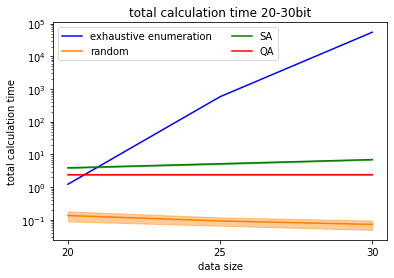

In [104]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_time_30['random'] + std_time_30['random'], mean_time_30['random'] - std_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_time_30['SA'] + std_time_30['SA'], mean_time_30['SA'] - std_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_time_30['QA'] + std_time_30['QA'], mean_time_30['QA'] - std_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('total calculation time 20-30bit')
plt.savefig('noeq/_30bit_total_calculation_time_mean_std_log.png')
plt.show()

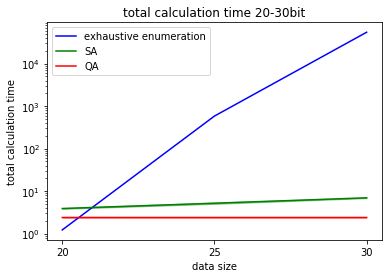

In [105]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_30, mean_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_time_30['random'] + std_time_30['random'], mean_time_30['random'] - std_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_time_30['SA'] + std_time_30['SA'], mean_time_30['SA'] - std_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_time_30['QA'] + std_time_30['QA'], mean_time_30['QA'] - std_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left')
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('total calculation time 20-30bit')
plt.savefig('noeq/norandom_30bit_total_calculation_time_mean_std_log.png')
plt.show()

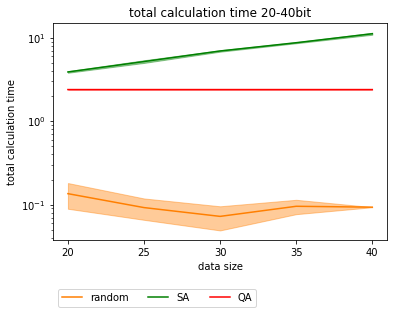

In [106]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('noeq/_40bit_total_calculation_time_mean_std_log.png')
plt.show()

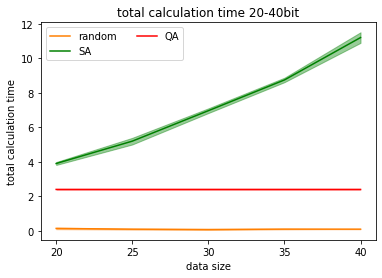

In [107]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('noeq/_40bit_total_calculation_time_mean_std.png')
plt.show()

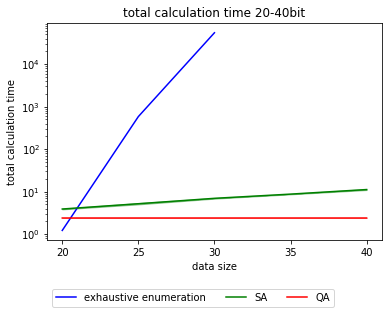

In [108]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
#ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00#ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00'#)
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('noeq/norandom_30bit_40bit_total_calculation_time_mean_log.png')
plt.show()

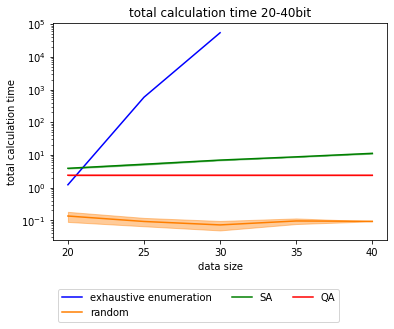

In [114]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('noeq/_30bit_40bit_total_calculation_time_mean_std_log.png')
plt.show()

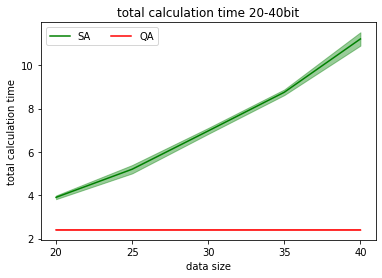

In [113]:
fig, ax = plt.subplots(1)

#ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_35, mean_time_35['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
#ax.fill_between(bit_list_35, mean_time_35['random'] + std_time_35['random'], mean_time_35['random'] - std_time_35['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#x.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('noeq/SAQA_40bit_total_calculation_time_mean_std.png')
plt.show()

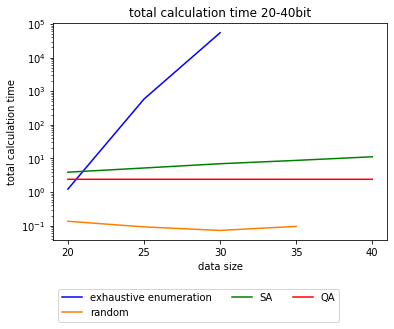

In [115]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_35, mean_time_35['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
#ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00#ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00'#)
#ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('noeq/_30bit_40bit_total_calculation_time_mean_log.png')
plt.show()

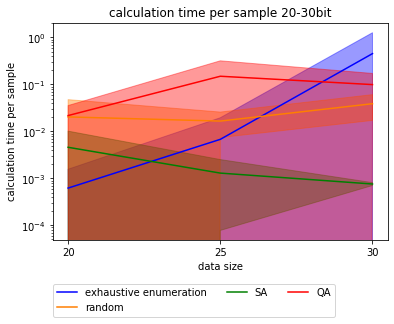

In [116]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('noeq/enustd_30bit_per_time_mean_std_log.png')
plt.show()

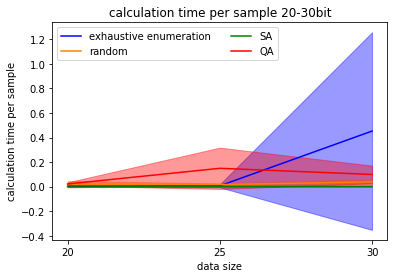

In [117]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
#plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('noeq/enustd_30bit_per_time_mean_std.png')
plt.show()

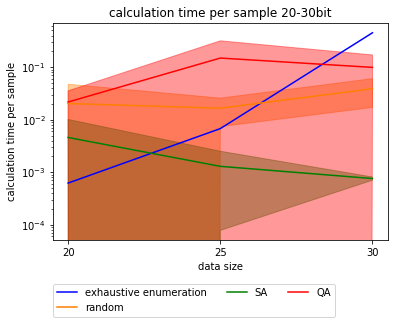

In [118]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('noeq/_30bit_per_time_mean_std_log.png')
plt.show()

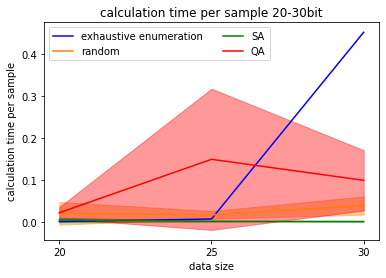

In [119]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
#plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('noeq/_30bit_per_time_mean_std.png')
plt.show()

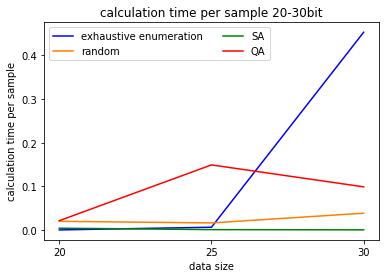

In [120]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
#plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('noeq/_30bit_per_time_mean.png')
plt.show()

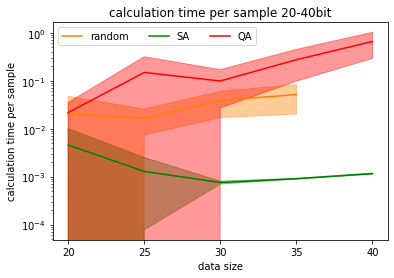

In [121]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_35, mean_per_time_35['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_35, mean_per_time_35['random'] + std_per_time_35['random'], mean_per_time_35['random'] - std_per_time_35['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('noeq/_35_40bit_per_time_mean_std_log.png')
plt.show()

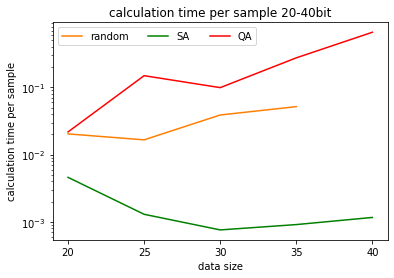

In [122]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_35, mean_per_time_35['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_35, mean_per_time_35['random'] + std_per_time_35['random'], mean_per_time_35['random'] - std_per_time_35['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('noeq/_35_40bit_per_time_mean_log.png')
plt.show()

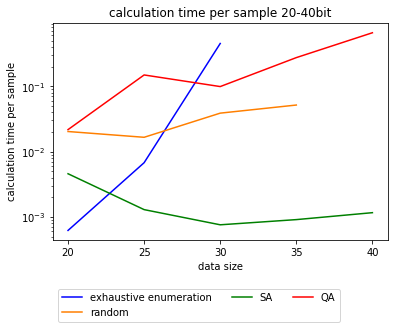

In [123]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_35, mean_per_time_35['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_35, mean_per_time_35['random'] + std_per_time_35['random'], mean_per_time_35['random'] - std_per_time_35['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('noeq/_30_40bit_per_time_mean_log.png')
plt.show()

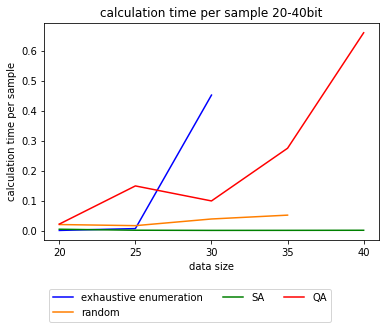

In [124]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_35, mean_per_time_35['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_35, mean_per_time_35['random'] + std_per_time_35['random'], mean_per_time_35['random'] - std_per_time_35['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('noeq/_30_40bit_per_time_mean.png')
plt.show()

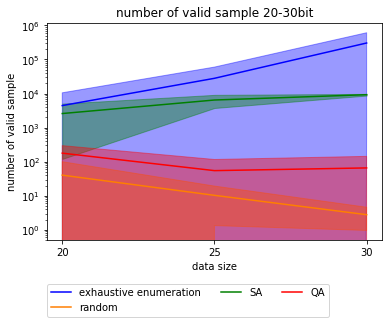

In [125]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('noeq/enustd_30bit_valid_y_num_mean_std_log.png')
plt.show()

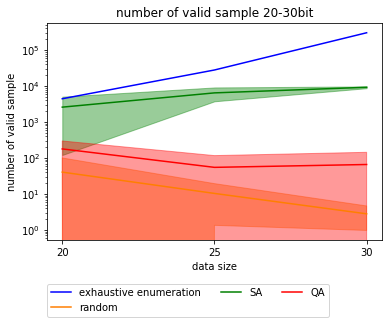

In [126]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('noeq/_30bit_valid_y_num_mean_std_log.png')
plt.show()

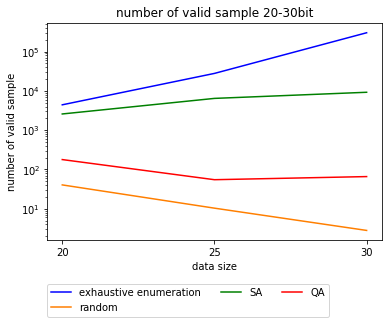

In [127]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('noeq/_30bit_valid_y_num_mean_log.png')
plt.show()

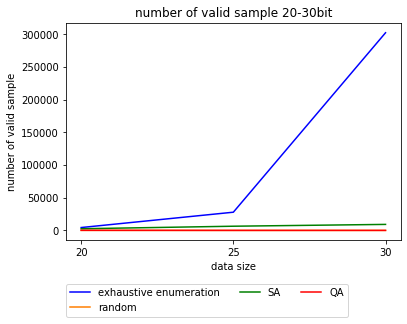

In [128]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('noeq/_30bit_valid_y_num_mean.png')
plt.show()

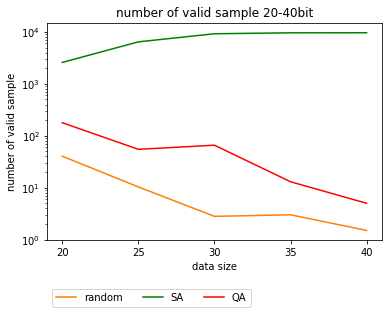

In [130]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_valid_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_valid_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_valid_y_num_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_35, mean_valid_y_num_35['random'] + std_valid_y_num_35['random'], mean_valid_y_num_35['random'] - std_valid_y_num_35['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_valid_y_num_40['SA'] + std_valid_y_num_40['SA'], mean_valid_y_num_40['SA'] - std_valid_y_num_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_valid_y_num_40['QA'] + std_valid_y_num_40['QA'], mean_valid_y_num_40['QA'] - std_valid_y_num_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('number of valid sample 20-40bit')
plt.savefig('noeq/_40bit_valid_y_num_mean_log.png')
plt.show()

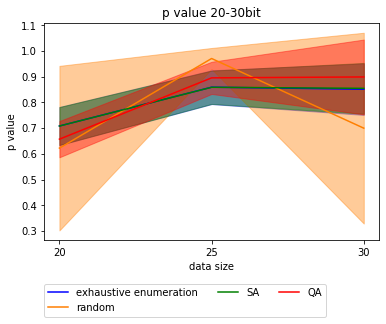

In [131]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_p_30['enumeration'] + std_p_30['enumeration'], mean_p_30['enumeration'] - std_p_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_p_30['random'] + std_p_30['random'], mean_p_30['random'] - std_p_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_p_30['SA'] + std_p_30['SA'], mean_p_30['SA'] - std_p_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_p_30['QA'] + std_p_30['QA'], mean_p_30['QA'] - std_p_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('noeq/enustd_30bit_p_mean_std.png')
plt.show()

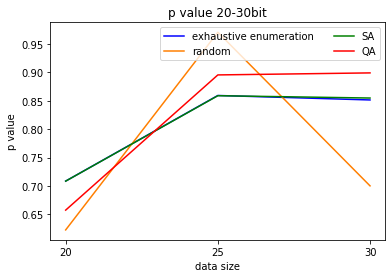

In [132]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_p_30['enumeration'] + std_p_30['enumeration'], mean_p_30['enumeration'] - std_p_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_p_30['random'] + std_p_30['random'], mean_p_30['random'] - std_p_30['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_30, mean_p_30['SA'] + std_p_30['SA'], mean_p_30['SA'] - std_p_30['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_30, mean_p_30['QA'] + std_p_30['QA'], mean_p_30['QA'] - std_p_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.legend(loc='upper right', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('noeq/_30bit_p_mean.png')
plt.show()

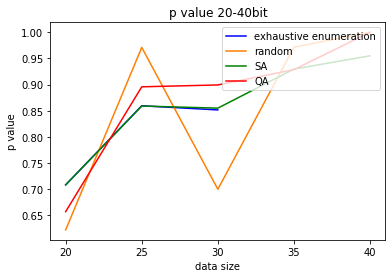

In [133]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('noeq/_30bit_40bit_p_mean.png')
plt.show()

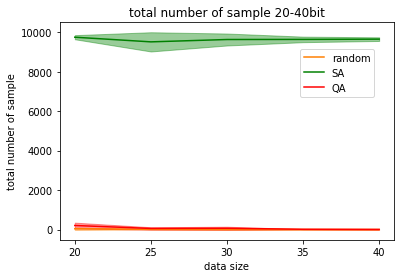

In [134]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('noeq/_40bit_total_y_num_mean_std.png')
plt.show()

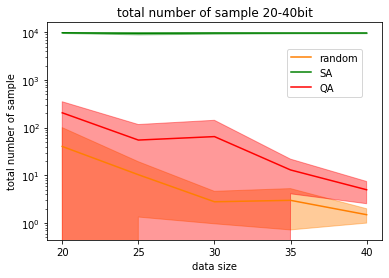

In [135]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('noeq/_35_40bit_total_y_num_mean_std_log.png')
plt.show()

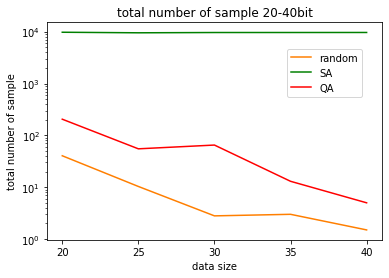

In [136]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('noeq/_35_40bit_total_y_num_mean_log.png')
plt.show()

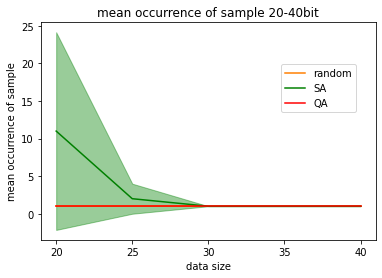

In [137]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_occurrence_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_occurrence_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_occurrence_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_occurrence_40['random'] + std_occurrence_40['random'], mean_occurrence_40['random'] - std_occurrence_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_occurrence_40['SA'] + std_occurrence_40['SA'], mean_occurrence_40['SA'] - std_occurrence_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_occurrence_40['QA'] + std_occurrence_40['QA'], mean_occurrence_40['QA'] - std_occurrence_40['QA'], alpha=0.4, color='r')

#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=2, fontsize=10)
ax.set_xlabel('data size')
ax.set_ylabel('mean occurrence of sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('mean occurrence of sample 20-40bit')
plt.savefig('noeq/_40bit_mean_occurrence_mean_std.png')
plt.show()

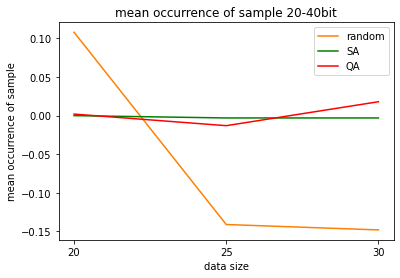

In [138]:
fig, ax = plt.subplots(1)

#enu = [0.292,0.141,0.148]
random = [0.108,-0.141,-0.148]
SA = [0.,-0.003,-0.003]
QA = [+0.002,-0.013,+0.018]

#ax.legend(loc='upper left', ncol=2)

#ax.plot(bit_list_30, enu)
ax.plot(bit_list_30, random, label='random', color='#ff7f00')
ax.plot(bit_list_30, SA, label='SA', color='g')
ax.plot(bit_list_30, QA, label='QA', color='r')

ax.legend(loc='upper right', ncol=1)
#plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=2, fontsize=10)
ax.set_xlabel('data size')
ax.set_ylabel('mean occurrence of sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('mean occurrence of sample 20-40bit')
plt.savefig('noeq/_30bit_p_value_enu_diff.png')
plt.show()

手法& 20bit & 25bit & 30bit \\
		全列挙 & $0.292$ & $0.141$ & $0.148$ \\
		\hline\hline
		ランダムサンプリング & $+0.108$ & $-0.141$ & $-0.148$ \\
		SA & $0.$ & $-0.003$ & $-0.003$ \\
		QA & $+0.002$ & $-0.013$ & $+0.018$ \\